# Doximity data analyst technical challenge

## Part I

The product manager has some questions on the data and is looking to you for some insight. Please provide your answer (and any applicable SQL queries you used to arrive at the answer):

### What is the average age of users by region?

In [12]:
import mysql.connector as sql

import pandas as pd

db_connection = sql.connect(host='54.86.230.73', 
                port=3316,user='candidate', passwd='Doximity', 
                db='candidate')
db_cursor = db_connection.cursor()
db_cursor.execute('SELECT region, AVG(age) FROM users GROUP BY region')

table_rows = db_cursor.fetchall()

q1 = pd.DataFrame(table_rows)

In [13]:
q1

,0,1
0,Midwest,38.1995
1,Northeast,36.6343
2,Other,38.0028
3,South,37.9134
4,West,37.0780


### Could you provide a breakdown of user title and number of user counts associated with each title?

In [16]:
db_cursor.execute('SELECT user_titles.title, COUNT(*) \
                    FROM user_titles, users \
                    WHERE users.title_id = user_titles.id \
                    GROUP BY user_titles.title')

table_rows = db_cursor.fetchall()

q2 = pd.DataFrame(table_rows)

In [17]:
q2

,0,1
0,Assistant professor,41977
1,Full professor,18907
2,Other,71231
3,Postdoctoral assistant,193847
4,Student,274038


### Who is the top viewed user, based on internal profile views?

In [18]:
db_cursor.execute('SELECT users.firstname, users.lastname, COUNT(*)\
                    FROM users, internal_profile_views\
                    WHERE viewed_user_id = users.id\
                    GROUP BY viewed_user_id\
                    ORDER BY COUNT(*) DESC\
                    LIMIT 1')

table_rows = db_cursor.fetchall()
q3 = pd.DataFrame(table_rows)

In [19]:
q3

,0,1,2
0,Tommy,Proulx,406


### Can you provide a ranked list of the top 10 most view users based on internal profile views, supplemented with data from the user table?

In [20]:
db_cursor.execute('SELECT users.firstname, users.lastname, users.age, users.region, COUNT(*)\
                    FROM users, internal_profile_views\
                    WHERE viewed_user_id = users.id\
                    GROUP BY viewed_user_id\
                    ORDER BY COUNT(*) DESC\
                    LIMIT 10')

table_rows = db_cursor.fetchall()
q4 = pd.DataFrame(table_rows)
q4

,0,1,2,3,4
0,Tommy,Proulx,20,Northeast,406
1,Adam,Towns,21,Midwest,383
2,Diane,Holland,24,South,180
3,Edna,Castillo,29,Midwest,88
4,Savannah,Murphy,21,Northeast,88
5,Shirley,Medina,60,Midwest,82
6,Sandra,Phillips,67,Midwest,68
7,Howard,Rivera,27,Midwest,67
8,Robert,Barron,65,South,61
9,Kathy,Saeteun,68,Midwest,47


### Which region gets the most viewed users (based on internal profile views)?

In [22]:
db_cursor.execute('SELECT users.region, COUNT(*)\
                    FROM users, internal_profile_views\
                    WHERE viewed_user_id = users.id\
                    GROUP BY users.region\
                    ORDER BY COUNT(*) DESC\
                    LIMIT 1')

table_rows = db_cursor.fetchall()
q5 = pd.DataFrame(table_rows)
q5

,0,1
0,Midwest,2908


## Part II

With these data, your goals are to understand and help the product manager understand how users are interacting with each others’ profiles, to understand how much web traffic user profiles are receiving and from where, to pull the data in a form that can generate a “Rank for profile views” feature, and to postulate how the data may best be presented in this product.

To this end, you should create one or two data visualizations to help the product manager understand the social network’s profile views data and write a brief summary communicating how the data may be used to drive the product forward.

**My Solution**

We can create a new table "Rank" with will have two columns: user_id and user_rank. We can calculate "user_rank" as a count of times the profile was viewed by the other users. I think, we need to exclude when a user views his own profile, thus I put viewed_user_id <> user_id. 

In [23]:
import mysql.connector as sql
import pandas as pd

db_connection = sql.connect(host='54.86.230.73', 
                port=3316,user='candidate', passwd='Doximity', 
                db='candidate')
db_cursor = db_connection.cursor()
db_cursor.execute('SELECT viewed_user_id, COUNT(*)\
                    FROM internal_profile_views\
                    WHERE viewed_user_id <> user_id\
                    GROUP BY viewed_user_id\
                    ORDER BY COUNT(*) DESC')

table_rows = db_cursor.fetchall()

df_users_rank = pd.DataFrame(table_rows)

In [25]:
df_users_rank.head()

,0,1
0,1740253,406
1,2185215,383
2,2632343,180
3,3086119,88
4,1287442,88


We also can create a table "user_activities" that will have two columns: "user_id" and "activites". We can calculate "activities" as a count of times the user viewed the other user profiles.

In [34]:
db_cursor.execute('SELECT user_id, COUNT(*)\
                    FROM internal_profile_views\
                    GROUP BY user_id\
                    ORDER BY COUNT(*) DESC')

table_rows = db_cursor.fetchall()

df_users_activ = pd.DataFrame(table_rows)

In [37]:
df_users_activ.head()

,0,1
0,762286,2
1,2099938,2
2,2952653,2
3,2089414,2
4,3941085,2


In [38]:
df_users_activ.tail()

,0,1
10705,1716141,1
10706,2864142,1
10707,672932,1
10708,4005604,1
10709,1731340,1


It looks like strange - every user viewed the profiles of other users one or two times only. Thus, I think, right now we do not need "user_activities" table. 

Now we can join the users table and our new "rank" table and make a visualization.

In [81]:
db_cursor.execute('SELECT * FROM users')

table_rows = db_cursor.fetchall()

users = pd.DataFrame(table_rows)
users.head()

,0,1,2,3,4,5
0,10038,Ida,Slostad,20,South,5
1,10039,David,Brown,36,Northeast,5
2,10040,Jack,Alcorn,60,Northeast,5
3,10041,Julie,Fremont,48,Other,6
4,10042,Trent,Long,32,Northeast,3


In [82]:
users.columns

RangeIndex(start=0, stop=6, step=1)

In [83]:
db_cursor.execute('SELECT * FROM user_titles')

table_rows = db_cursor.fetchall()

user_titles = pd.DataFrame(table_rows)
user_titles

,0,1
0,2,Assistant professor
1,1,Full professor
2,6,Other
3,3,Postdoctoral assistant
4,5,Student


In [84]:
users_with_rank = pd.merge(users, df_users_rank, how='left', on=[0, 0])

In [85]:
users_with_rank.head()

,0,1_x,2,3,4,5,1_y
0,10038,Ida,Slostad,20,South,5,NaN
1,10039,David,Brown,36,Northeast,5,NaN
2,10040,Jack,Alcorn,60,Northeast,5,NaN
3,10041,Julie,Fremont,48,Other,6,NaN
4,10042,Trent,Long,32,Northeast,3,NaN


In [91]:
users_with_rank.columns = ['id', 'first_name', 'last_name', 'age', 'region', 'titile_id', 'rank']
users_with_rank.head()

,id,first_name,last_name,age,region,titile_id,rank
0,10038,Ida,Slostad,20,South,5,NaN
1,10039,David,Brown,36,Northeast,5,NaN
2,10040,Jack,Alcorn,60,Northeast,5,NaN
3,10041,Julie,Fremont,48,Other,6,NaN
4,10042,Trent,Long,32,Northeast,3,NaN


In [92]:
users_with_rank_not_0 = users_with_rank.dropna()

In [93]:
users_with_rank_not_0.shape

(5464, 7)

In [94]:
users_with_rank.shape

(600000, 7)

It is very interesting - only 5464 profiles from 600000 where viewed by somebody. 

Let's make some visualizations for only profiles that got attention. 

In [95]:
users_with_rank_not_0['rank'].max()

406.0

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

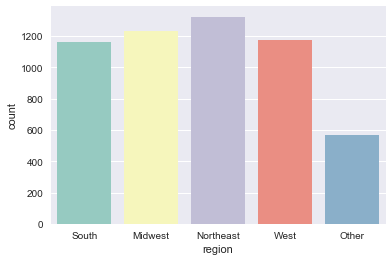

In [77]:
sns.countplot(data=users_with_rank_not_0, x='region', palette = "Set3")

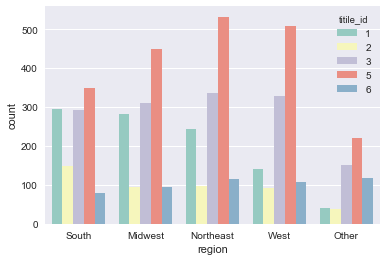

In [74]:
sns.countplot(data=users_with_rank_not_0, x='region',hue="titile_id", palette = "Set3")

**titile_id: **

*1 - Full professor,

*2 - Assistant professor,

*3 - Postdoctoral assistant,

*5 - Student,

*6 - Other

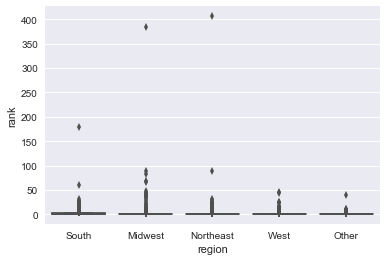

In [75]:
sns.boxplot(x="region", y="rank", data=users_with_rank_not_0, palette='rainbow')

It looks like we have very few very popular profiles and the most of profiles got less than 50 views.

## Conclusion

The most interesting about this data is that all users are not very active - everyone viewed only one or two profiles. Also, it is interesting that there are few very popular profiles with rating up to 406, but most profiles we viewed 0 times!

I think, we need to add "rank" table with user_id and the number of times the profile of this user was viewed. 